##  Contexto


Una empresa emergente, que vende productos alimenticios, solicita investigar el comportamiento del usuario para la aplicación.

Primero, se va a estudiar el embudo de ventas. Cómo los usuarios llegan a la etapa de compra. ¿Cuántos usuarios realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observaremos los resultados de un test A/A/B. Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

Los usuarios se dividen en tres grupos: dos grupos de control (246 y 247) obtienen las fuentes antiguas y un grupo de prueba (248) obtiene las nuevas. Analizaremos qué conjunto de fuentes produce mejores resultados.

Crear dos grupos A tiene ciertas ventajas, por ejemplo poder establecer el principio de que solo confiaremos en la exactitud de nuestras pruebas cuando los dos grupos de control sean similares. Si hay diferencias significativas entre los grupos A, esto ayudará a descubrir factores que pueden estar distorsionando los resultados. La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizaremos el mismo dataset para el análisis general y para el análisis A/A/B. 

### Descripción de los datos
Cada entrada de registro es una acción de usuario o un evento.

- EventName: nombre del evento.

- DeviceIDHash: identificador de usuario unívoco.

- EventTimestamp: hora del evento.

- ExpId: número de experimento.




### 1. Se importan las librerías y los datos para leer la información general

In [944]:
# importo librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import math as mth



#Accedemos a los datos y preparamos los DFs
#data = pd.read_csv('/datasets/logs_exp_us.csv')
data  = pd.read_csv('logs_exp_us.csv', sep="\t")

#observamos los datos
display(data)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246



### 2. Preparar los datos para el análisis

In [945]:

#Cambiamos los nombres de las columnas
data.columns = ['event', 'user', 'date_time', 'group_id']


In [946]:
#Analizamos con qué tipo de datos estamos trabajando, si hay valores nulos y duplicados
display(data.info())
print('cantidad de valores ausentes:')
print(data.isna().sum())
print('cantidad de valores duplicados')
print(data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      244126 non-null  object
 1   user       244126 non-null  int64 
 2   date_time  244126 non-null  int64 
 3   group_id   244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

cantidad de valores ausentes:
event        0
user         0
date_time    0
group_id     0
dtype: int64
cantidad de valores duplicados
413


De 244126 datos/eventos registrados, existen más de 400 datos duplicados, estos serán eliminados acontinuación. 

In [947]:
#guardamos los duplicados en un df aparte
data_raw = data.copy()

#Eliminamos datos duplicados del DF que estamos trabajando
data = data.drop_duplicates()

In [948]:
#cambiamos tipo de datos de la columna event: object a category
data['event'] = data['event'].astype('category')

In [949]:
#pasamos los datos de la columna fecha al tipo datetime
data['date_time'] = pd.to_datetime(data['date_time'], unit='s')

#creo columna solo para la fecha 
data['date'] = data['date_time'].dt.date



### 3. Estudiar y comprobar los datos


In [950]:
#Cúantos eventos hay en los registros:
print('cantidad de eventos únicos registrados: ', data['event'].nunique())

#Cúantos eventos hay en los registros por grupo:
print('cantidad de eventos únicos registrados en grupo A: ', data[data['group_id'] == 246]['event'].nunique())
print('cantidad de eventos únicos registrados en grupo A2: ', data[data['group_id'] == 247]['event'].nunique())
print('cantidad de eventos únicos registrados en grupo B: ', data[data['group_id'] == 248]['event'].nunique())
print('')
#cantidad de usuarios únicos:
print('cantidad de usuarios únicos: ', data['user'].nunique())

#cantidad de usuarios únicos por grupo:
print('cantidad de usuarios únicos en grupo A: ', data[data['group_id'] == 246]['user'].nunique())
print('cantidad de usuarios únicos en grupo A2: ', data[data['group_id'] == 247]['user'].nunique())
print('cantidad de usuarios únicos en grupo B: ', data[data['group_id'] == 248]['user'].nunique())


cantidad de eventos únicos registrados:  5
cantidad de eventos únicos registrados en grupo A:  5
cantidad de eventos únicos registrados en grupo A2:  5
cantidad de eventos únicos registrados en grupo B:  5

cantidad de usuarios únicos:  7551
cantidad de usuarios únicos en grupo A:  2489
cantidad de usuarios únicos en grupo A2:  2520
cantidad de usuarios únicos en grupo B:  2542


In [951]:
# Calculamos cantidad de eventos por usuario

mean_event_user = data.groupby('user')['event'].count().reset_index()
#cambiamos el nombre a las columnas
mean_event_user.columns = ['user', 'amount_of_events']

print(mean_event_user['amount_of_events'].describe())


count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: amount_of_events, dtype: float64


In [952]:
# Calculamos cantidad de eventos por usuario por grupo, en este caso grupo A

mean_event_user_GA = data[data['group_id'] == 246].groupby('user')['event'].count().reset_index()
#cambiamos el nombre a las columnas
mean_event_user_GA.columns = ['user', 'amount_of_events']

print('GRUPO A:')
print(mean_event_user_GA['amount_of_events'].describe())

# Calculamos cantidad de eventos por usuario por grupo, en este caso grupo A2

mean_event_user_GA2 = data[data['group_id'] == 247].groupby('user')['event'].count().reset_index()
#cambiamos el nombre a las columnas
mean_event_user_GA2.columns = ['user', 'amount_of_events']

print('GRUPO A2:')
print(mean_event_user_GA2['amount_of_events'].describe())

# Calculamos cantidad de eventos por usuario por grupo, en este caso grupo B

mean_event_user_GB = data[data['group_id'] == 248].groupby('user')['event'].count().reset_index()
#cambiamos el nombre a las columnas
mean_event_user_GB.columns = ['user', 'amount_of_events']

print('GRUPO B:')
print(mean_event_user_GB['amount_of_events'].describe())


GRUPO A:
count    2489.000000
mean       32.214142
std        65.085668
min         1.000000
25%         9.000000
50%        19.000000
75%        37.000000
max      1998.000000
Name: amount_of_events, dtype: float64
GRUPO A2:
count    2520.000000
mean       30.932540
std        56.304849
min         1.000000
25%         9.000000
50%        19.500000
75%        37.000000
max      1768.000000
Name: amount_of_events, dtype: float64
GRUPO B:
count    2542.000000
mean       33.667191
std        72.931171
min         1.000000
25%         9.000000
50%        20.000000
75%        38.000000
max      2307.000000
Name: amount_of_events, dtype: float64


Podemos observar que: la min cantidad de eventos es 1, la máxima de 2307. El promedio de eventos por usuario es de 32, menos del 50% llegan a los 20 eventos por usuario, es decir, la media y la mediana están muy diferenciadas entre sí. La desviación estandar es muy grande: 65, lo cual se refleja en los datos que se mencionan, es decir, que hay datos anómalos que hacen a los datos menos estables.

Ahora bien, si separamos por grupo podemos observar que hasta el 75% los 3 grupos presentan  casi las mismas cifras min: 1, 25%: 9, 50% 19/20, 75% 37/38. La gran diferencia se nota en el máximo o en todo lo que supere a ese 75%, y esto afecta a la desviación estándar.

Grafiquemos para poder observar mejor lo mencionado al principio y por debajo cada grupo:

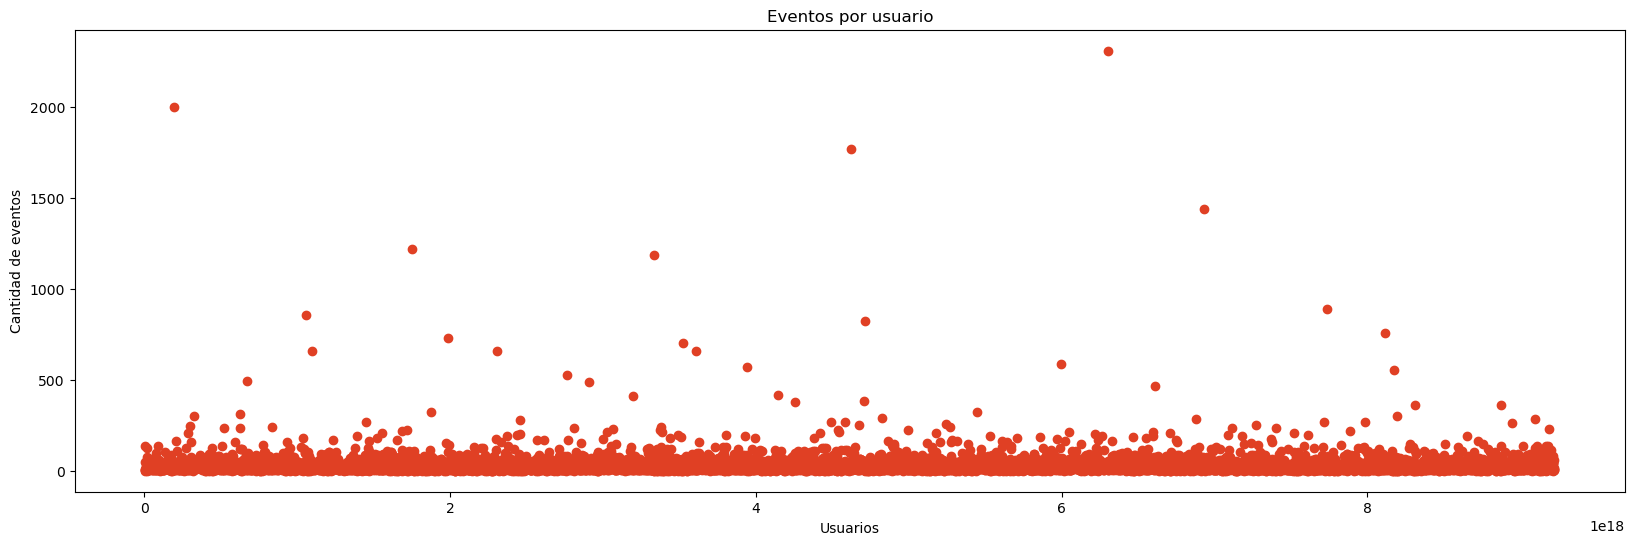

In [953]:
#graficar para ver mejor la cantidad de evento por usuario
plt.figure(figsize=[20,6])
plt.title('Eventos por usuario')
plt.scatter(mean_event_user['user'], mean_event_user['amount_of_events'], color="#E04024")
plt.xlabel('Usuarios')
plt.ylabel('Cantidad de eventos')
plt.show()


Se observan claramente valores anómalos, que de los más de 7000 registros, aparecen puntos en el gráfico con exhuberante cantidad de eventos por usuario. 

Veamos cómo se observa esto si la cantidad de eventos es menor a 500.

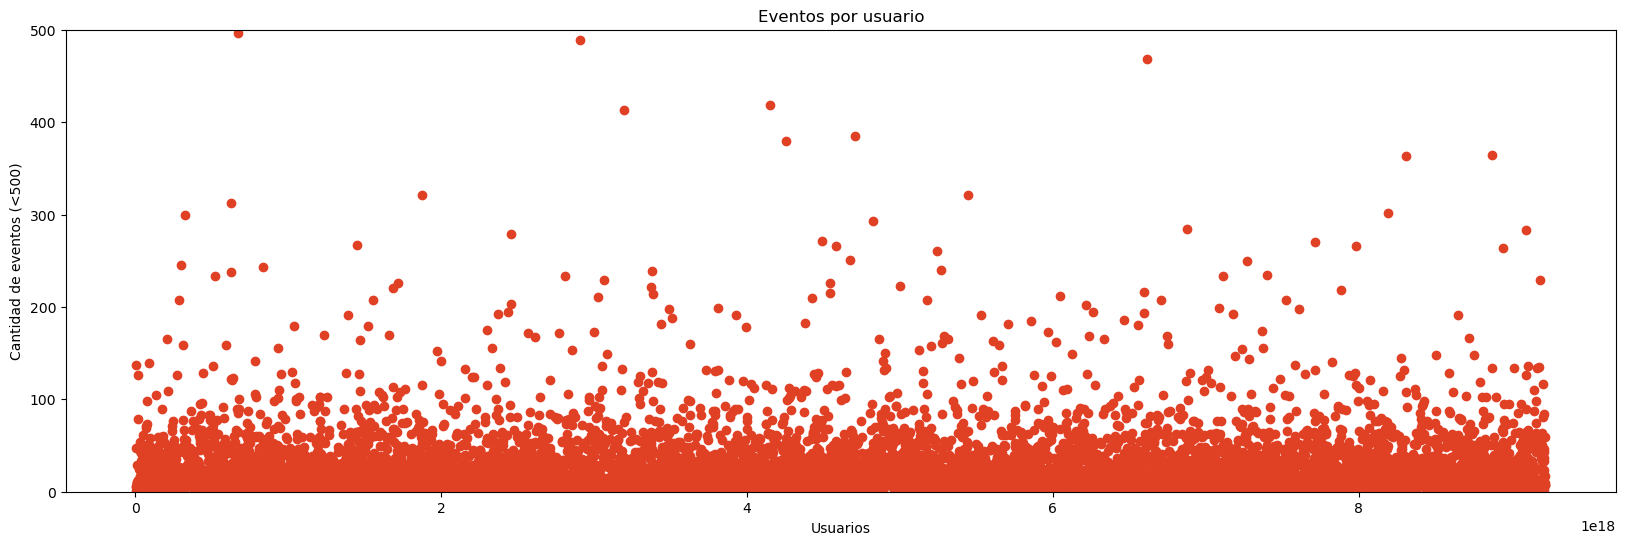

In [954]:
#Achicamos los valores del eje y (cantidad de eventos por usuario) a 500
plt.figure(figsize=[20,6])
plt.title('Eventos por usuario')
plt.scatter(mean_event_user['user'], mean_event_user['amount_of_events'], color="#E04024")
plt.xlabel('Usuarios')
plt.ylabel('Cantidad de eventos (<500)')
plt.ylim(0,500)
plt.show()


si bien los puntos (datos/usuarios) se encuentran más cerca entre sí, según lo analizado previamente se dice que el 75% de los usuarios tienen no más de 37 eventos por usuario.

Veamos si se reduce un poco más la cantidad de eventos, ahora a 100.

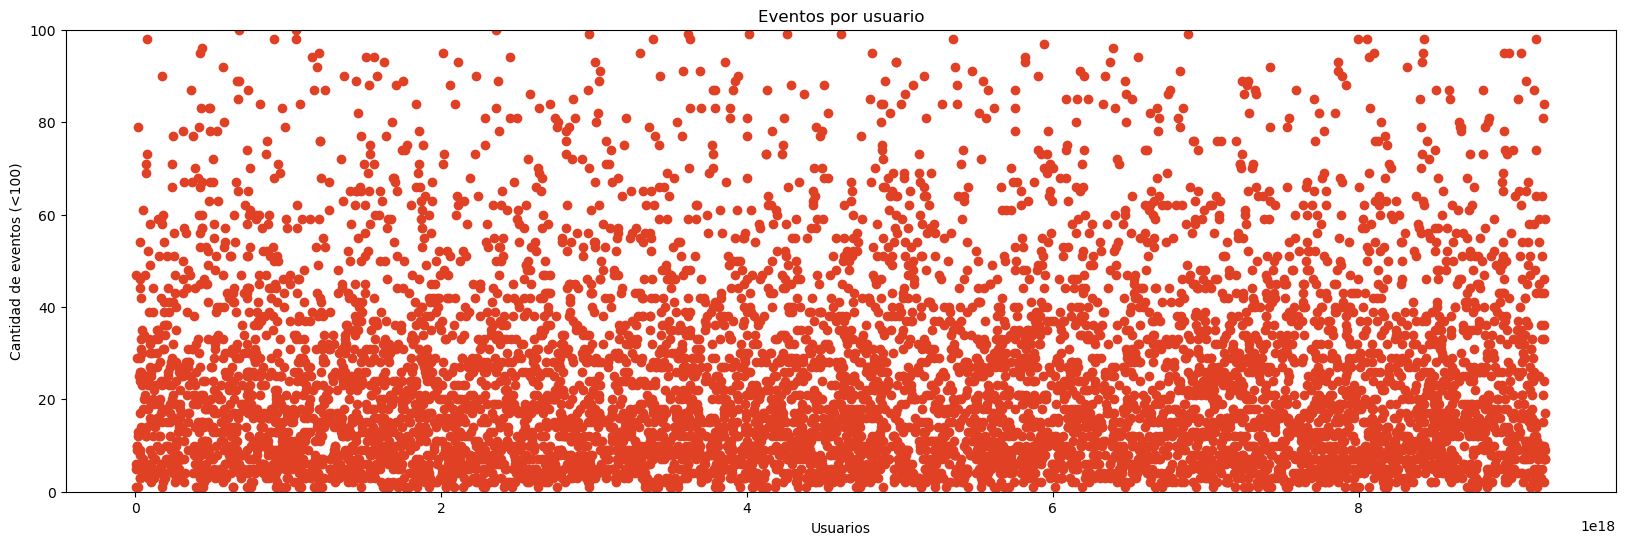

In [955]:
#Achicamos los valores del eje y (cantidad de eventos por usuario) a 100
plt.figure(figsize=[20,6])
plt.title('Eventos por usuario')
plt.scatter(mean_event_user['user'], mean_event_user['amount_of_events'], color="#E04024")
plt.xlabel('Usuarios')
plt.ylabel('Cantidad de eventos (<100)')
plt.ylim(0,100)
plt.show()

Graficamos cómo se observa la distribución de los eventos por usuario según cada grupo

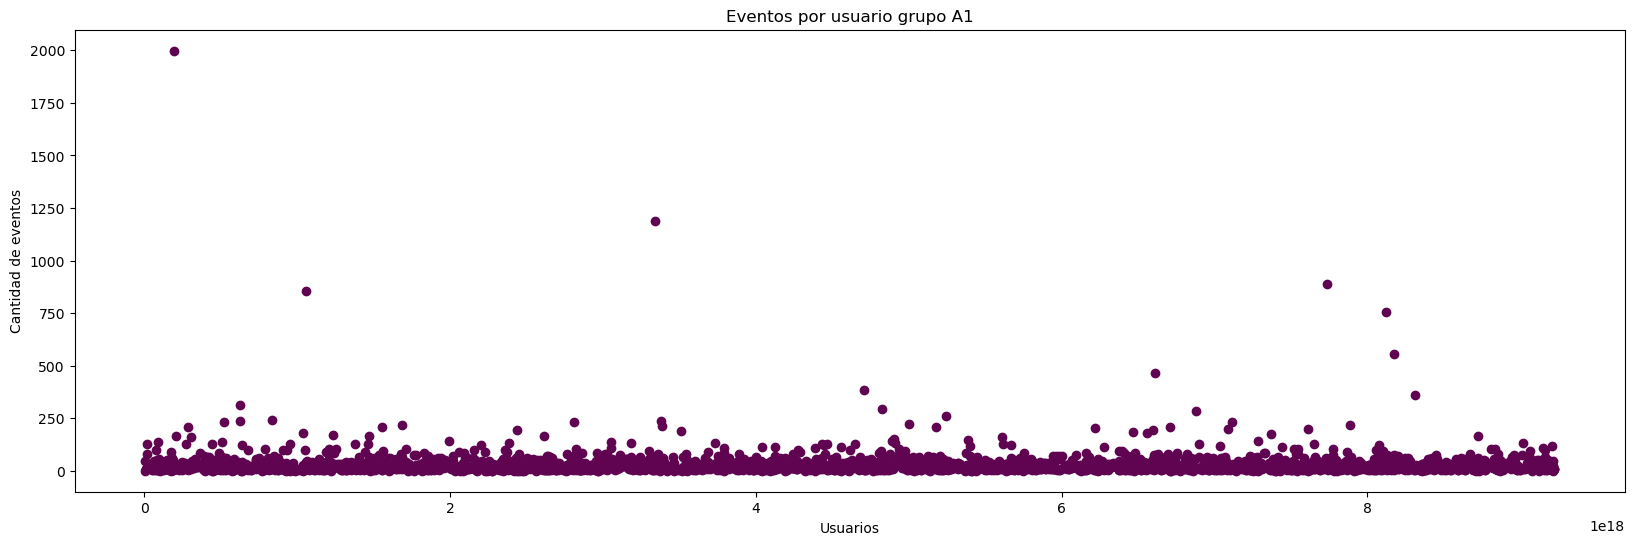

In [956]:
#graficar para ver mejor la cantidad de evento por usuario grupo A
plt.figure(figsize=[20,6])
plt.title('Eventos por usuario grupo A1')
plt.scatter(mean_event_user_GA['user'], mean_event_user_GA['amount_of_events'], color="#600452")
plt.xlabel('Usuarios')
plt.ylabel('Cantidad de eventos')
plt.show()

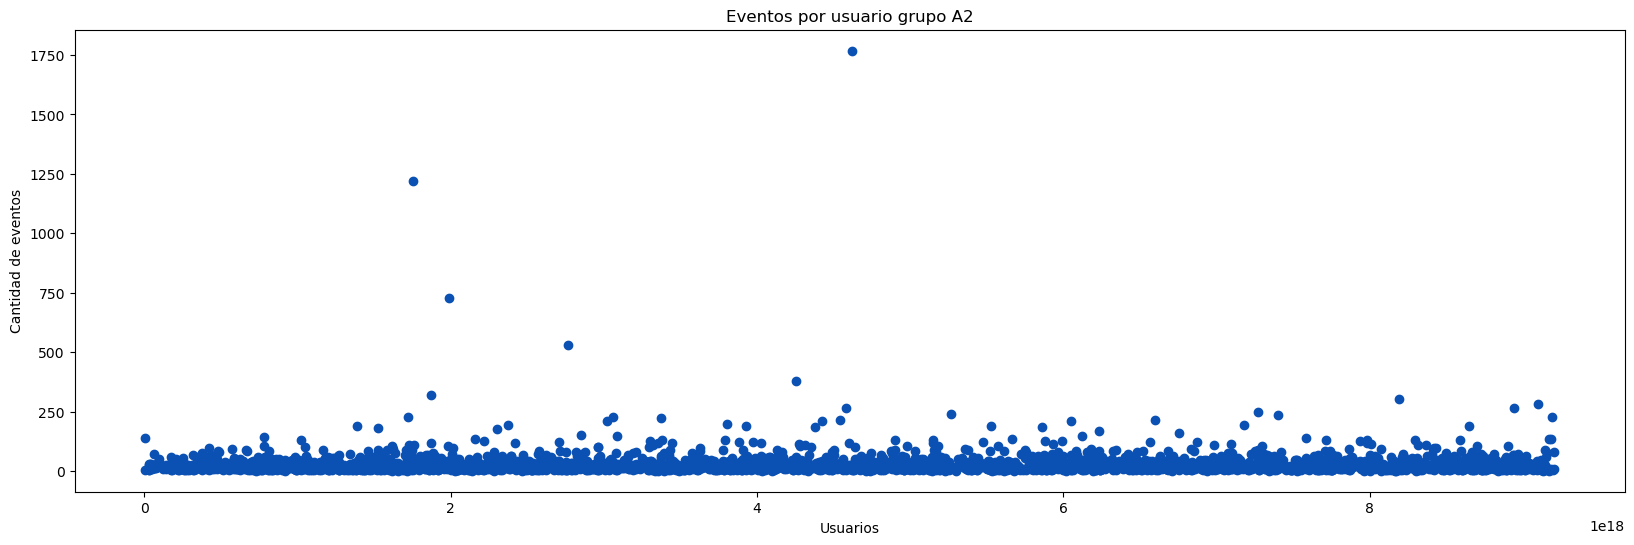

In [957]:
#graficar para ver mejor la cantidad de evento por usuario grupo A
plt.figure(figsize=[20,6])
plt.title('Eventos por usuario grupo A2')
plt.scatter(mean_event_user_GA2['user'], mean_event_user_GA2['amount_of_events'], color="#0B51B4")
plt.xlabel('Usuarios')
plt.ylabel('Cantidad de eventos')
plt.show()

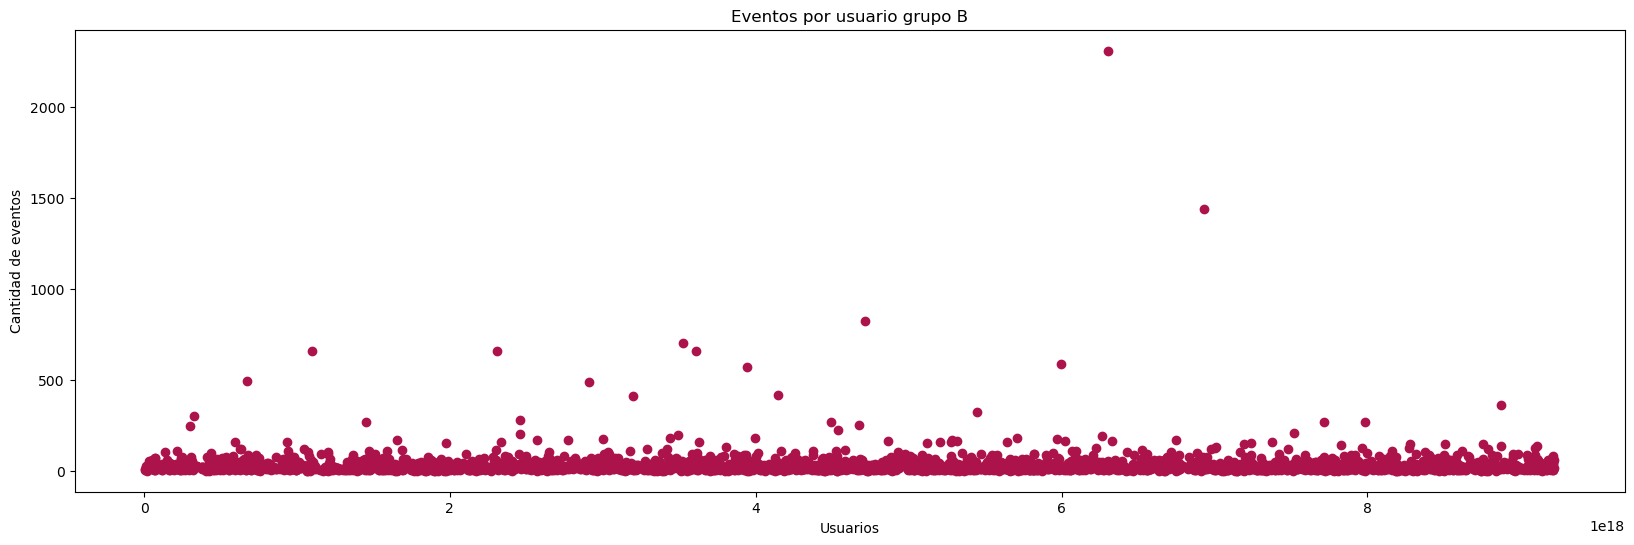

In [958]:
#graficar para ver mejor la cantidad de evento por usuario grupo A
plt.figure(figsize=[20,6])
plt.title('Eventos por usuario grupo B')
plt.scatter(mean_event_user_GB['user'], mean_event_user_GB['amount_of_events'], color="#AD134B")
plt.xlabel('Usuarios')
plt.ylabel('Cantidad de eventos')
plt.show()

Tiempo que llevan registrándose estos datos:  2019-07-25 04:43:36  -  2019-08-07 21:15:17


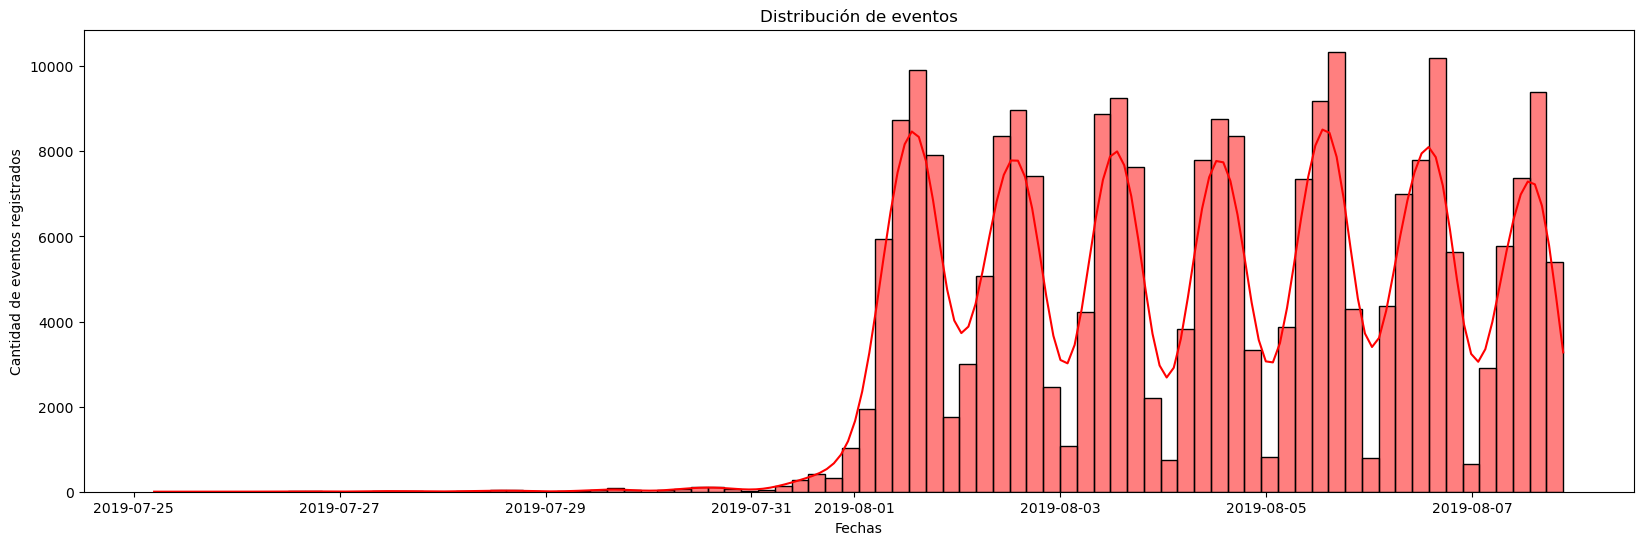

In [959]:
# Cuánto tiempo de datos tengo registrados
print('Tiempo que llevan registrándose estos datos: ', data['date_time'].min(), " - ", data['date_time'].max())

# Traza un histograma por fecha y hora.
plt.figure(figsize=[20,6])
plt.title('Distribución de eventos')
sns.histplot(data['date_time'], bins=84, kde=True, color='red')
plt.xlabel('Fechas')
plt.ylabel('Cantidad de eventos registrados')
plt.show()


Si bien hay algunos registros a partir del 25 de julio, parecen aislados. Observemos cómo se ve en una tabla por día cada evento registrado y cuantos datos hay en cada grupo

In [960]:
#agrupamos segun fecha cantidad de eventos registrados y cuantos grupos aparecen en dichos registros

data_pivot = data.pivot_table(index='date', columns='group_id', values='event', aggfunc='count')
print(data_pivot)

group_id      246    247    248
date                           
2019-07-25      4      1      4
2019-07-26     14      8      9
2019-07-27     24     23      8
2019-07-28     33     36     36
2019-07-29     55     58     71
2019-07-30    129    138    145
2019-07-31    620    664    746
2019-08-01  11561  12306  12274
2019-08-02  10946  10990  13618
2019-08-03  10575  11024  11683
2019-08-04  11514   9942  11512
2019-08-05  12368  10949  12741
2019-08-06  11726  11720  12342
2019-08-07  10612  10091  10393


La mayor cantidad de registros son a partir del 1° de agosto, por lo que se observa en la tabla no se perderían gran cantidad de datos si se descarta la primera semana de eventos registrados en cada grupo.



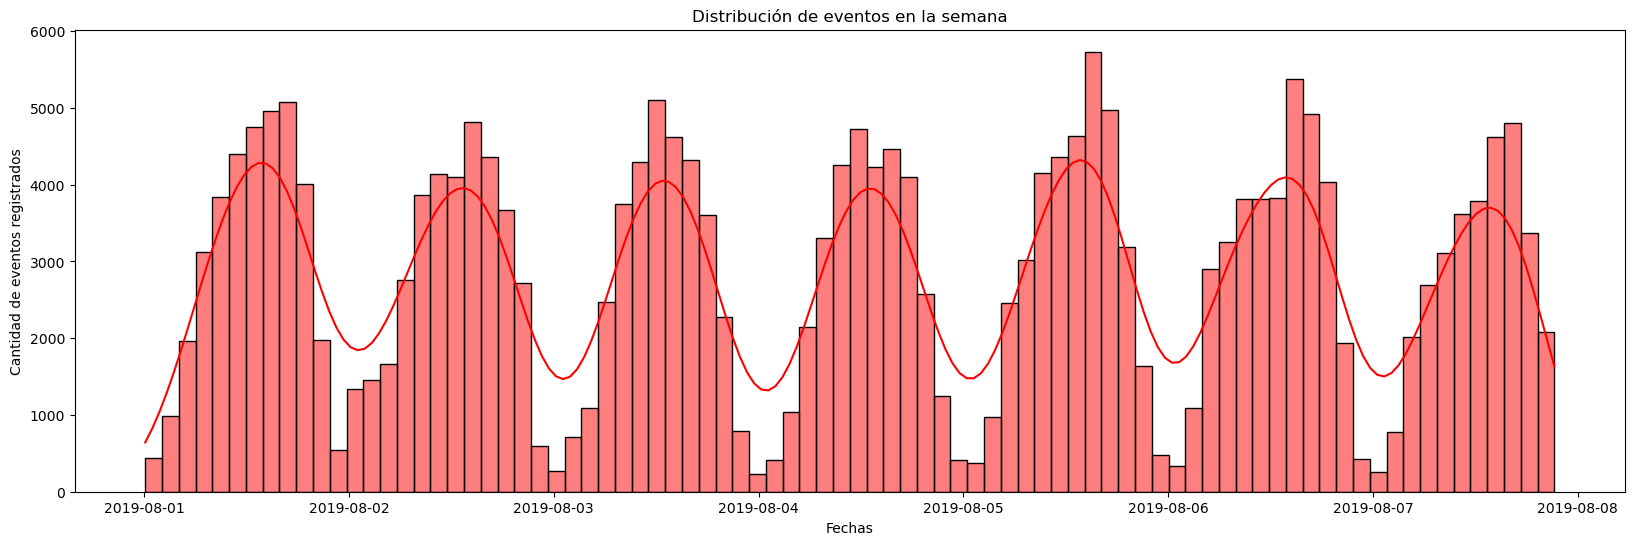

In [961]:
#vamos a crear un nuevo DF con los eventos registrado a partir del 1° de agosto
data_filtrado = data[data['date_time'].between('2019-08-01', '2019-08-07 23:59:59')]

#graficamos para ver los datos a partir del 1ro de agosto
plt.figure(figsize=[20,6])
plt.title('Distribución de eventos en la semana')
sns.histplot(data_filtrado['date_time'], bins=84, kde=True, color='red')
plt.xlabel('Fechas')
plt.ylabel('Cantidad de eventos registrados')
plt.show()

Se puede observar una mejor distribución de los datos tomando como fecha del inicio el 1ro de agosto hasta el 7 del mismo mes y como varía la cantidad de datos registrados a lo largo del día.

In [962]:
#confirmamos con una tabla cómo se ven segun las fechas, la cantidad de eventos registrados por grupo
data_filtrado_pivot = data_filtrado.pivot_table(index='date', columns='group_id', values='event', aggfunc='count')
print(data_filtrado_pivot)

group_id      246    247    248
date                           
2019-08-01  11561  12306  12274
2019-08-02  10946  10990  13618
2019-08-03  10575  11024  11683
2019-08-04  11514   9942  11512
2019-08-05  12368  10949  12741
2019-08-06  11726  11720  12342
2019-08-07  10612  10091  10393


Se observa que hay suficiente cantidad de datos con los cuales trabajar, y no se han perdido cantidades significativas de registro de datos.


### 4. Estudiar el embudo de eventos

event       CartScreenAppear  MainScreenAppear  OffersScreenAppear  \
date                                                                 
2019-08-01              6217             17945                6988   
2019-08-02              6522             16792                6924   
2019-08-03              6374             14832                6795   
2019-08-04              6155             15203                6487   
2019-08-05              6248             18005                6666   
2019-08-06              5733             18761                6533   
2019-08-07              5054             15790                5940   

event       PaymentScreenSuccessful  Tutorial  
date                                           
2019-08-01                     4771       220  
2019-08-02                     5148       168  
2019-08-03                     5119       162  
2019-08-04                     4983       140  
2019-08-05                     5024       115  
2019-08-06                     46

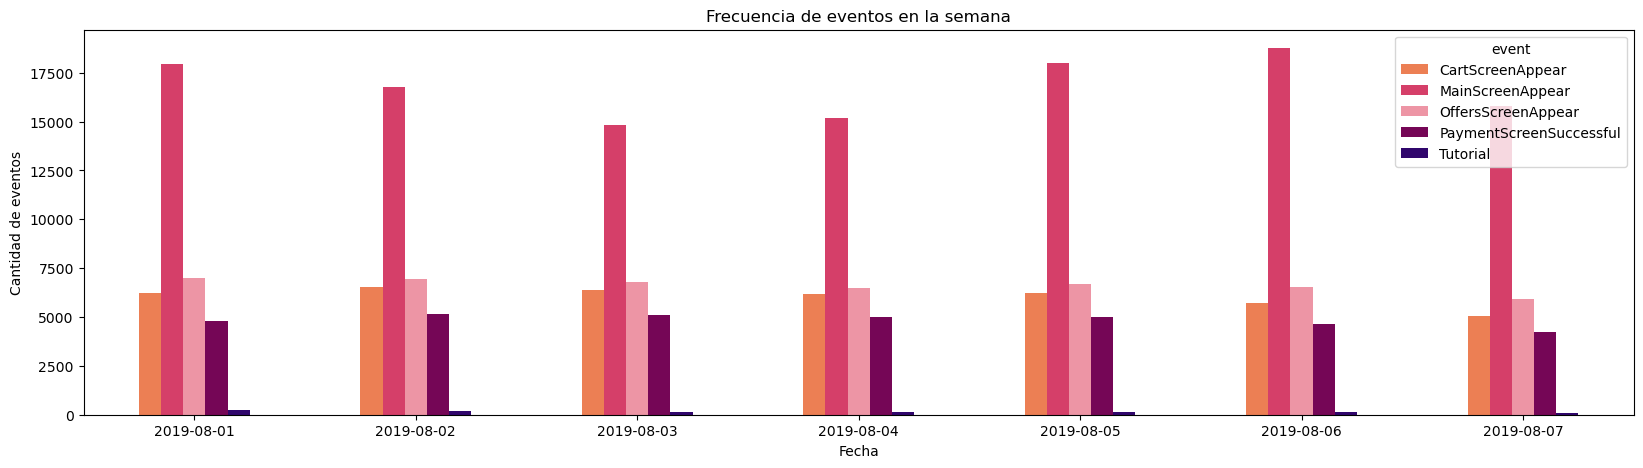

In [963]:
#Cómo se ven los eventos en la semana según la cantidad de usuarios
events = data_filtrado.pivot_table(index='date', columns='event', values='user', aggfunc='count', observed=True)
events.plot(kind='bar', title='Frecuencia de eventos en la semana', figsize=[20,5], rot=360, xlabel='Fecha', ylabel='Cantidad de eventos', color=["#EC7F54", "#D53F69", "#ED95A5", "#750656", "#30066C"])

print(events)

In [964]:
#Frecuencia de suceso por evento
events_total = data_filtrado.groupby('event')['user'].count().reset_index().sort_values(by='user', ascending=False)
print(events_total)

#Frecuencia de suceso por evento por grupo
print('Grupo A1:')
events_total_GA = data_filtrado[data_filtrado['group_id'] == 246].groupby('event')['user'].count().reset_index().sort_values(by='user', ascending=False)
print(events_total_GA)
print('Grupo A2:')
events_total_GA2 = data_filtrado[data_filtrado['group_id'] == 247].groupby('event')['user'].count().reset_index().sort_values(by='user', ascending=False)
print(events_total_GA2)
print('Grupo B:')
events_total_GB = data_filtrado[data_filtrado['group_id'] == 248].groupby('event')['user'].count().reset_index().sort_values(by='user', ascending=False)
print(events_total_GB)

                     event    user
1         MainScreenAppear  117328
2       OffersScreenAppear   46333
0         CartScreenAppear   42303
3  PaymentScreenSuccessful   33918
4                 Tutorial    1005
Grupo A1:
                     event   user
1         MainScreenAppear  37676
2       OffersScreenAppear  14767
0         CartScreenAppear  14690
3  PaymentScreenSuccessful  11852
4                 Tutorial    317
Grupo A2:
                     event   user
1         MainScreenAppear  39090
2       OffersScreenAppear  15179
0         CartScreenAppear  12434
3  PaymentScreenSuccessful   9981
4                 Tutorial    338
Grupo B:
                     event   user
1         MainScreenAppear  40562
2       OffersScreenAppear  16387
0         CartScreenAppear  15179
3  PaymentScreenSuccessful  12085
4                 Tutorial    350


/var/folders/b2/lv6qp5j57qsg2gyqh4np3lgw0000gn/T/ipykernel_24397/1734256343.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events_total = data_filtrado.groupby('event')['user'].count().reset_index().sort_values(by='user', ascending=False)
/var/folders/b2/lv6qp5j57qsg2gyqh4np3lgw0000gn/T/ipykernel_24397/1734256343.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events_total_GA = data_filtrado[data_filtrado['group_id'] == 246].groupby('event')['user'].count().reset_index().sort_values(by='user', ascending=False)
/var/folders/b2/lv6qp5j57qsg2gyqh4np3lgw0000gn/T/ipykernel_24397/1734256343.py:10: FutureWa

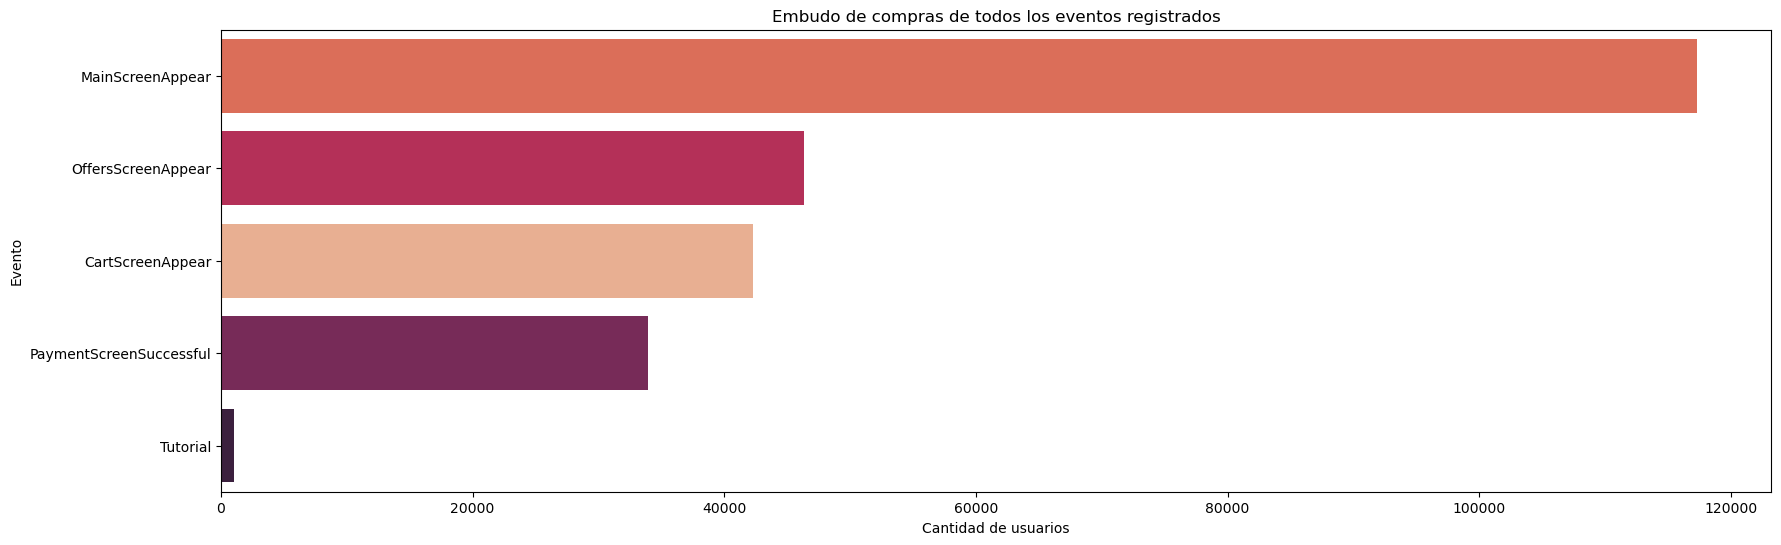

In [965]:
#Graficamos para poder ver cómo se observan estos datos
plt.figure(figsize=[20,6])
sns.barplot(data=events_total, y='event', x='user', color='purple', order=['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'], palette='rocket_r', hue='event')
plt.ylabel('Evento')
plt.xlabel('Cantidad de usuarios')
plt.title('Embudo de compras de todos los eventos registrados')
sns.color_palette('tab10')
plt.show()

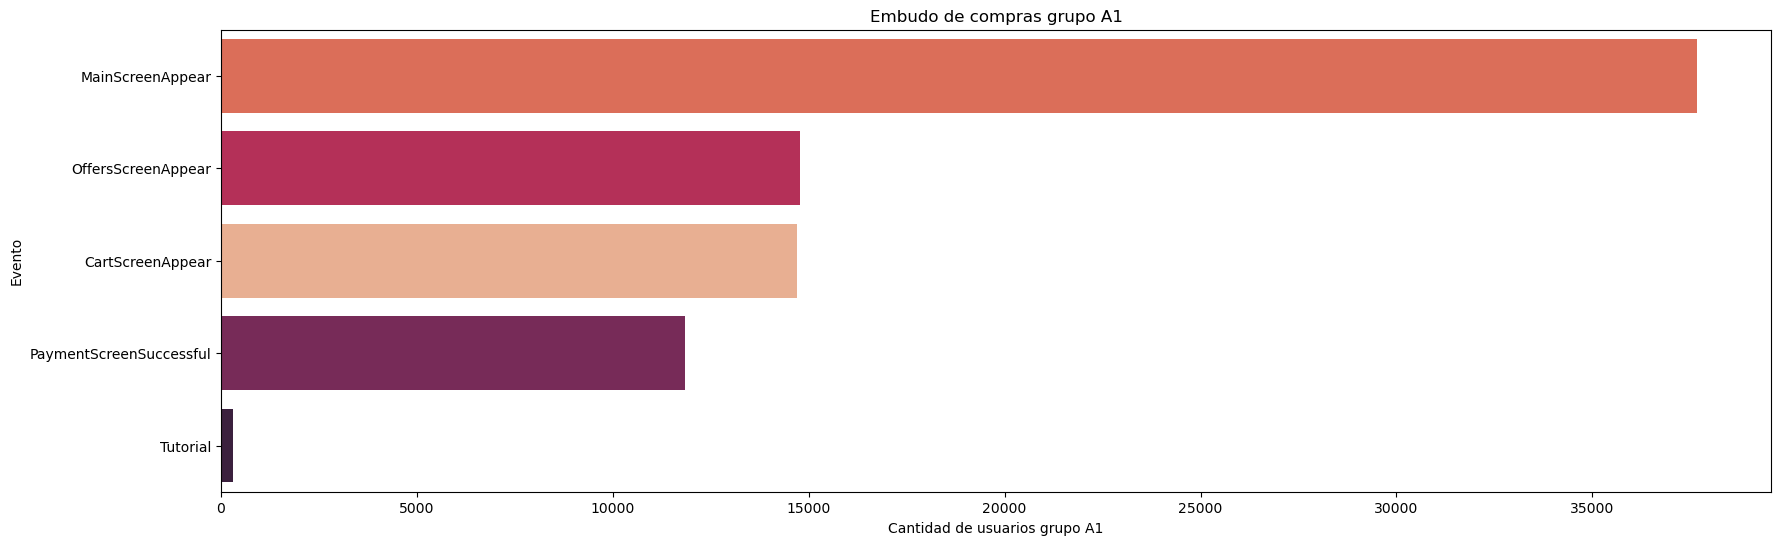

In [966]:
plt.figure(figsize=[20,6])
sns.barplot(data=events_total_GA, y='event', x='user', color='purple', order=['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'], palette='rocket_r', hue='event')
plt.ylabel('Evento')
plt.xlabel('Cantidad de usuarios grupo A1')
plt.title('Embudo de compras grupo A1')
sns.color_palette('tab10')
plt.show()

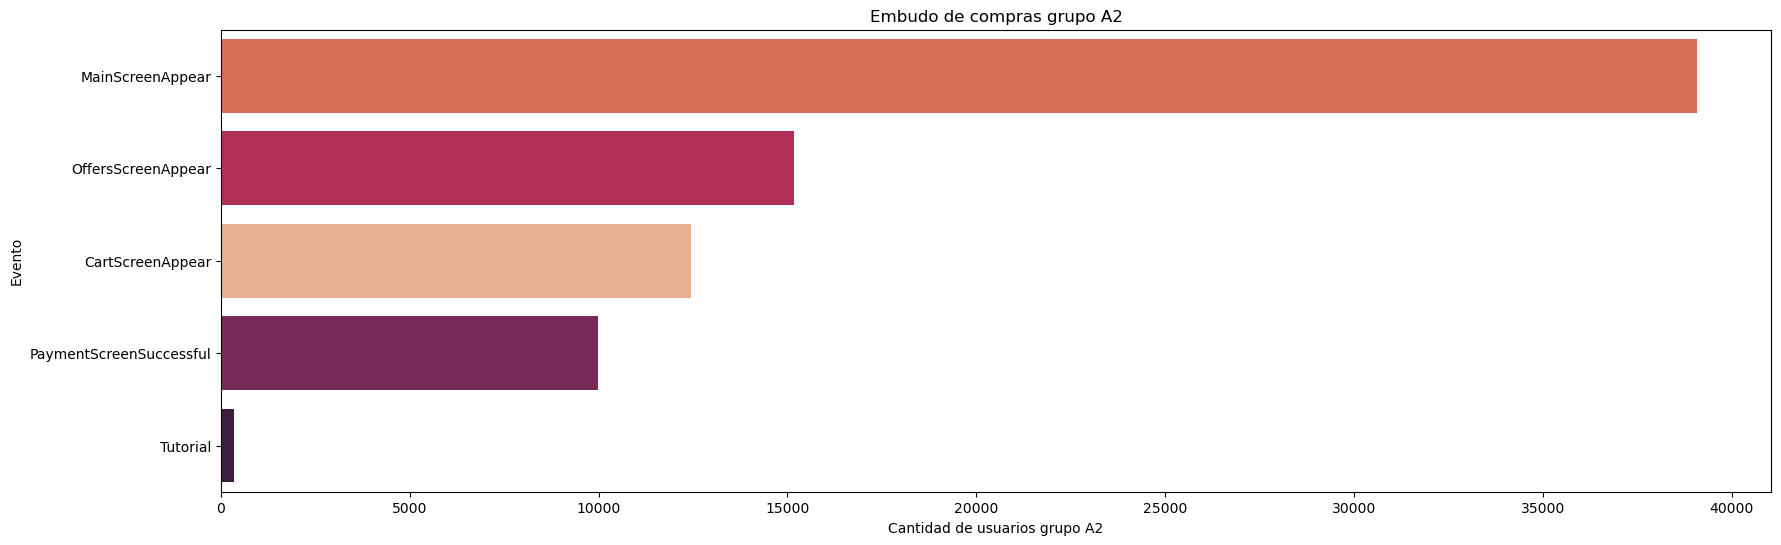

In [967]:
plt.figure(figsize=[20,6])
sns.barplot(data=events_total_GA2, y='event', x='user', color='purple', order=['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'], palette='rocket_r', hue='event')
plt.ylabel('Evento')
plt.xlabel('Cantidad de usuarios grupo A2')
plt.title('Embudo de compras grupo A2')
sns.color_palette('tab10')
plt.show()

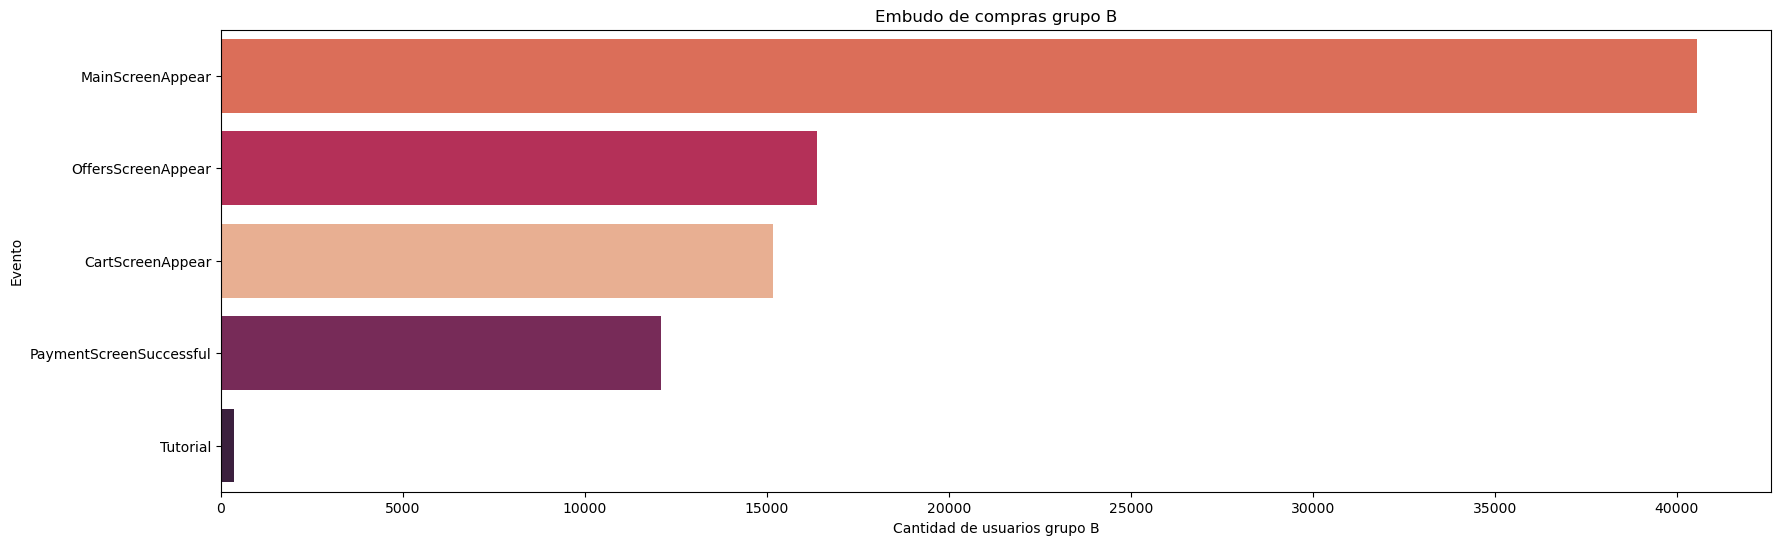

In [968]:
plt.figure(figsize=[20,6])
sns.barplot(data=events_total_GB, y='event', x='user', color='purple', order=['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial'], palette='rocket_r', hue='event')
plt.ylabel('Evento')
plt.xlabel('Cantidad de usuarios grupo B')
plt.title('Embudo de compras grupo B')
sns.color_palette('tab10')
plt.show()

In [969]:
# Qué cantidad de usuarios realizaron cada una de estas acciones. 
total_users_in_events = data_filtrado.groupby('event')['user'].nunique().reset_index().sort_values(by='user', ascending=False)

# Qué cantidad de usuarios realizaron cada una de estas acciones por grupo
users_in_events_A = data_filtrado[data_filtrado['group_id'] == 246].groupby('event')['user'].nunique().reset_index().sort_values(by='user', ascending=False)
users_in_events_A2 = data_filtrado[data_filtrado['group_id'] == 247].groupby('event')['user'].nunique().reset_index().sort_values(by='user', ascending=False)
users_in_events_B = data_filtrado[data_filtrado['group_id'] == 248].groupby('event')['user'].nunique().reset_index().sort_values(by='user', ascending=False)


#calculamos el total de usuarios para sacar % acontinuación
total_users = data_filtrado['user'].nunique()
#grupo A
total_users_GA = data_filtrado[data_filtrado['group_id'] == 246]['user'].nunique()
#grupo A2
total_users_GA2 = data_filtrado[data_filtrado['group_id'] == 247]['user'].nunique()
#grupo B
total_users_GB = data_filtrado[data_filtrado['group_id'] == 248]['user'].nunique()


# Calculamos la proporción de usuarios que realizaron la acción al menos una vez
total_users_in_events['users_%'] = (total_users_in_events['user'] / total_users * 100).round(2)
users_in_events_A['users_%'] = (users_in_events_A['user'] / total_users_GA * 100).round(2)
users_in_events_A2['users_%'] = (users_in_events_A2['user'] / total_users_GA2 * 100).round(2)
users_in_events_B['users_%'] = (users_in_events_B['user'] / total_users_GB * 100).round(2)



print(total_users_in_events)
print('Grupo A1')
print(users_in_events_A)
print('Grupo A2')
print(users_in_events_A2)
print('Grupo B')
print(users_in_events_B)



                     event  user  users_%
1         MainScreenAppear  7419    98.47
2       OffersScreenAppear  4593    60.96
0         CartScreenAppear  3734    49.56
3  PaymentScreenSuccessful  3539    46.97
4                 Tutorial   840    11.15
Grupo A1
                     event  user  users_%
1         MainScreenAppear  2450    98.63
2       OffersScreenAppear  1542    62.08
0         CartScreenAppear  1266    50.97
3  PaymentScreenSuccessful  1200    48.31
4                 Tutorial   278    11.19
Grupo A2
                     event  user  users_%
1         MainScreenAppear  2476    98.53
2       OffersScreenAppear  1520    60.49
0         CartScreenAppear  1238    49.26
3  PaymentScreenSuccessful  1158    46.08
4                 Tutorial   283    11.26
Grupo B
                     event  user  users_%
1         MainScreenAppear  2493    98.27
2       OffersScreenAppear  1531    60.35
0         CartScreenAppear  1230    48.48
3  PaymentScreenSuccessful  1181    46.55
4       

/var/folders/b2/lv6qp5j57qsg2gyqh4np3lgw0000gn/T/ipykernel_24397/4284803389.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_users_in_events = data_filtrado.groupby('event')['user'].nunique().reset_index().sort_values(by='user', ascending=False)
/var/folders/b2/lv6qp5j57qsg2gyqh4np3lgw0000gn/T/ipykernel_24397/4284803389.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  users_in_events_A = data_filtrado[data_filtrado['group_id'] == 246].groupby('event')['user'].nunique().reset_index().sort_values(by='user', ascending=False)
/var/folders/b2/lv6qp5j57qsg2gyqh4np3lgw0000gn/T/ipykernel_24397/4284803389.

Teniendo en cuenta el total de los datos registrados, y por grupo, la mayor cantidad de usuarios entran principalmente a la pantalla/página principal.

Un 11% utiliza el tutorial, con lo cual no parece ser parte de la "ruta del usuario", sino una opción y esto se demuestra en los 3 grupos.

Las ofertas también parecen parte de una opción, a la cual el 60/62% de los usuarios acceden.

Sin embargo el carrito y la finalización de la compra son sin duda una parte de la ruta del usuario. En ellos los números son similares en los tres grupos: entre un 46 y un 50%


In [970]:
#Suponiendo que las etapas son: Main >> Offers >> Carts >> PaymentSuccess vamos a calcular qué proporción de clientes pasa de una etapa a la siguiente
#tutorial se cuenta como opcional
total_users_in_events['convert_%'] = ((total_users_in_events['user'] / total_users_in_events['user'].shift(1))*100).round(2)
users_in_events_A['convert_%'] = ((users_in_events_A['user'] / users_in_events_A['user'].shift(1))*100).round(2)
users_in_events_A2['convert_%'] = ((users_in_events_A2['user'] / users_in_events_A2['user'].shift(1))*100).round(2)
users_in_events_B['convert_%'] = ((users_in_events_B['user'] / users_in_events_B['user'].shift(1))*100).round(2)


#calculamos cantidad de usuarios que se perdieron de una página/paso al otro
total_users_in_events['dropped_%'] = 100 - total_users_in_events['convert_%']
users_in_events_A['dropped_%'] = 100 - users_in_events_A['convert_%']
users_in_events_A2['dropped_%'] = 100 - users_in_events_A2['convert_%']
users_in_events_B['dropped_%'] = 100 - users_in_events_B['convert_%']

print('Total de usuarios')
print(total_users_in_events)
print('Grupo A1')
print(users_in_events_A)
print('Grupo A2')
print(users_in_events_A2)
print('Grupo B')
print(users_in_events_B)

Total de usuarios
                     event  user  users_%  convert_%  dropped_%
1         MainScreenAppear  7419    98.47        NaN        NaN
2       OffersScreenAppear  4593    60.96      61.91      38.09
0         CartScreenAppear  3734    49.56      81.30      18.70
3  PaymentScreenSuccessful  3539    46.97      94.78       5.22
4                 Tutorial   840    11.15      23.74      76.26
Grupo A1
                     event  user  users_%  convert_%  dropped_%
1         MainScreenAppear  2450    98.63        NaN        NaN
2       OffersScreenAppear  1542    62.08      62.94      37.06
0         CartScreenAppear  1266    50.97      82.10      17.90
3  PaymentScreenSuccessful  1200    48.31      94.79       5.21
4                 Tutorial   278    11.19      23.17      76.83
Grupo A2
                     event  user  users_%  convert_%  dropped_%
1         MainScreenAppear  2476    98.53        NaN        NaN
2       OffersScreenAppear  1520    60.49      61.39      38.61
0   

Teniendo en cuenta que el recorrido del usuario es: Main >> Offers >> Carts >> PaymentSuccess, y que la pagina de tutorial es solo una opcion (teniendo en cuenta el % de usuarios que se registran), vemos que el cerca del 47% de los usuarios realizan todo el recorrido.

Donde se ve mayor pérdida o engagement del usuario es en las ofertas, donde el 38% abandona la página. Se puede dar por varias razones: no están encontrando lo que buscan dentro de las ofertas, las ofertas no les parecen tales, o sólo estaban checkeando la sección.

Se puede observar que el grupo B tiene mayor conversión en el último evento: payment successful con un 96%, a diferencia de los grupos de control que no llegan al 95%. Sin embargo, en el porcentaje sobre el total de clientes es menor que en el grupo de control A1.


### 5. Estudiar los resultados del experimento



In [971]:
#Calculamos cantidad de eventos en cada grupo para probar la hipotesis de que la cantidad de los mismos son potencialmente iguales.


sampleA = data_filtrado[data_filtrado['group_id'] == 246]
sampleA2 = data_filtrado[data_filtrado['group_id'] == 247]
sampleB = data_filtrado[data_filtrado['group_id'] == 248]
sampleAA = data_filtrado[data_filtrado['group_id'].isin([246,247])]

#agrupo por eventos

sampleA = sampleA.groupby('event').size().reset_index(name='cantidad').sort_values(by='cantidad', ascending=False)
sampleA2 = sampleA2.groupby('event').size().reset_index(name='cantidad').sort_values(by='cantidad', ascending=False)
sampleB = sampleB.groupby('event').size().reset_index(name='cantidad').sort_values(by='cantidad', ascending=False)
sampleAA = sampleAA.groupby('event').size().reset_index(name='cantidad').sort_values(by='cantidad', ascending=False)

#calculamos proporción de éxito para cada grupo
sampleA['conv_acum'] = (sampleA['cantidad'] / sampleA['cantidad'][1]).round(2)
sampleA2['conv_acum'] = (sampleA2['cantidad'] / sampleA2['cantidad'][1] ).round(2)
sampleB['conv_acum'] = (sampleB['cantidad'] / sampleB['cantidad'][1]).round(2)
sampleAA['conv_acum'] = (sampleAA['cantidad'] / sampleAA['cantidad'][1]).round(2)

print(f"""
    Grupo A1:
    {sampleA}
    
    Grupo A2:
    {sampleA2}
    
    Grupo B:
    {sampleB}
    
    Grupo Control (A1+A2):
    {sampleAA}
    """)


    Grupo A1:
                         event  cantidad  conv_acum
1         MainScreenAppear     37676       1.00
2       OffersScreenAppear     14767       0.39
0         CartScreenAppear     14690       0.39
3  PaymentScreenSuccessful     11852       0.31
4                 Tutorial       317       0.01

    Grupo A2:
                         event  cantidad  conv_acum
1         MainScreenAppear     39090       1.00
2       OffersScreenAppear     15179       0.39
0         CartScreenAppear     12434       0.32
3  PaymentScreenSuccessful      9981       0.26
4                 Tutorial       338       0.01

    Grupo B:
                         event  cantidad  conv_acum
1         MainScreenAppear     40562       1.00
2       OffersScreenAppear     16387       0.40
0         CartScreenAppear     15179       0.37
3  PaymentScreenSuccessful     12085       0.30
4                 Tutorial       350       0.01

    Grupo Control (A1+A2):
                         event  cantidad  conv_acum


/var/folders/b2/lv6qp5j57qsg2gyqh4np3lgw0000gn/T/ipykernel_24397/2756630549.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampleA = sampleA.groupby('event').size().reset_index(name='cantidad').sort_values(by='cantidad', ascending=False)
/var/folders/b2/lv6qp5j57qsg2gyqh4np3lgw0000gn/T/ipykernel_24397/2756630549.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampleA2 = sampleA2.groupby('event').size().reset_index(name='cantidad').sort_values(by='cantidad', ascending=False)
/var/folders/b2/lv6qp5j57qsg2gyqh4np3lgw0000gn/T/ipykernel_24397/2756630549.py:13: FutureWarning: The default of observed=Fals

In [ ]:

#Checkeamos si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.
def dif_estadistica_ga (i, evento):
    alpha = 0.05 #nivel de significacion
    
    pA = sampleA['conv_acum'][i] 
    pA2 = sampleA2['conv_acum'][i]
    
    ## proporción de éxito en los grupos A - A2 unidos
    p_combined_A = ((sampleA['cantidad'][i] + sampleA2['cantidad'][i]) / (sampleA['cantidad'][1] + sampleA2['cantidad'][1])).round(2)

    #la diferencia entre las proporciones de los grupos A - A2
    difference_A = pA - pA2

    #calcula la estadística en desviaciones estándar de la distribución normal estándar
    z_value_a = difference_A / mth.sqrt(p_combined_A * (1- p_combined_A) * (1/sampleA['cantidad'][1] + 1/sampleA2['cantidad'][1]))

    # establece la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1) 


    p_value_a_bi = (1- distr.cdf(abs(z_value_a))) * 2
    

    print('p-value : ', p_value_a_bi)

    if (p_value_a_bi < alpha):
        return print(f"Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y {evento}")
    else:
        return print(f"No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Main Screen y {evento} son diferentes")


#comparamos si hay diferencia significativa entre los grupos del evento: main screen y offers
dif_estadistica_ga(2, 'Offers')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y carrito
dif_estadistica_ga(0, 'Carrito')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y pago realizado
dif_estadistica_ga(3, 'Pago Realizado')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y tutorial
dif_estadistica_ga(4, 'Tutorial')


p-value :  1.0
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Main Screen y Offers son diferentes
p-value :  0.0
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Carrito
p-value :  0.0
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Pago Realizado
p-value :  1.0
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Main Screen y Tutorial son diferentes


In [ ]:
#Checkeamos si hay una diferencia estadísticamente significativa entre las muestras 246 y 248.
def dif_estadistica_ga1_b (i, evento):
    alpha = 0.05 #nivel de significacion
    
    pA = sampleA['conv_acum'][i] 
    pB = sampleB['conv_acum'][i]
    
    ## proporción de éxito en los grupos A1 - B unidos
    p_combined_A1_B = ((sampleA['cantidad'][i] + sampleB['cantidad'][i]) / (sampleA['cantidad'][1] + sampleB['cantidad'][1])).round(2)

    #la diferencia entre las proporciones de los grupos A1 - B
    difference_A = pA - pB

    #calcula la estadística en desviaciones estándar de la distribución normal estándar
    z_value_a1_b = difference_A / mth.sqrt(p_combined_A1_B * (1- p_combined_A1_B) * (1/sampleA['cantidad'][1] + 1/sampleB['cantidad'][1]))

    # establece la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1) 

    p_value_a1_b = (1- distr.cdf(abs(z_value_a1_b))) * 2

    print('p-value: ', p_value_a1_b)

    if (p_value_a1_b < alpha):
        return print(f"Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y {evento}")
    else:
        return print(f"No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Main Screen y {evento} son diferentes")


#comparamos si hay diferencia significativa entre los grupos del evento: main screen y offers
dif_estadistica_ga1_b(2, 'Offers')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y carrito
dif_estadistica_ga1_b(0, 'Carrito')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y pago realizado
dif_estadistica_ga1_b(3, 'Pago Realizado')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y tutorial
dif_estadistica_ga1_b(4, 'Tutorial')

p-value:  0.004333028120803162
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Offers
p-value:  8.475685486786233e-09
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Carrito
p-value:  0.0025120666119704538
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Pago Realizado
p-value:  1.0
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Main Screen y Tutorial son diferentes


In [ ]:
#Checkeamos si hay una diferencia estadísticamente significativa entre las muestras 247 y 248.
def dif_estadistica_ga2_b (i, evento):
    alpha = 0.05 #nivel de significacion
    
    pA2 = sampleA2['conv_acum'][i] 
    pB = sampleB['conv_acum'][i]
    
    ## proporción de éxito en los grupos A - B unidos
    p_combined_A2_B = ((sampleA2['cantidad'][i] + sampleB['cantidad'][i]) / (sampleA2['cantidad'][1] + sampleB['cantidad'][1])).round(2)

    #la diferencia entre las proporciones de los grupos A - B
    difference_a2_b = pA2 - pB

    #calcula la estadística en desviaciones estándar de la distribución normal estándar
    z_value_a2_b = difference_a2_b / mth.sqrt(p_combined_A2_B * (1- p_combined_A2_B) * (1/sampleA2['cantidad'][1] + 1/sampleB['cantidad'][1]))

    # establece la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1) 

    p_value_a2_b = (1- distr.cdf(abs(z_value_a2_b))) * 2
    

    print('p-value: ', p_value_a2_b)

    if (p_value_a2_b < alpha):
        return print(f"Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y {evento}")
    else:
        return print(f"No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Main Screen y {evento} son diferentes")


#comparamos si hay diferencia significativa entre los grupos del evento: main screen y offers
dif_estadistica_ga2_b(2, 'Offers')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y carrito
dif_estadistica_ga2_b(0, 'Carrito')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y pago realizado
dif_estadistica_ga2_b(3, 'Pago Realizado')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y tutorial
dif_estadistica_ga2_b(4, 'Tutorial')

p-value:  0.00397708091379112
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Offers
p-value:  0.0
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Carrito
p-value:  0.0
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Pago Realizado
p-value:  1.0
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Main Screen y Tutorial son diferentes


In [ ]:
#Checkeamos si hay una diferencia estadísticamente significativa entre los grupos de control y el grupo B.
def dif_estadistica_gc_b (i, evento):
    alpha = 0.05 #nivel de significacion
    
    pAA = sampleAA['conv_acum'][i] 
    pB = sampleB['conv_acum'][i]
    
    ## proporción de éxito en los grupos A - B unidos
    p_combined_AA_B = ((sampleAA['cantidad'][i] + sampleB['cantidad'][i]) / (sampleAA['cantidad'][1] + sampleB['cantidad'][1])).round(2)

    #la diferencia entre las proporciones de los grupos A - B
    difference_AA_b = pAA - pB

    #calcula la estadística en desviaciones estándar de la distribución normal estándar
    z_value_AA_b = difference_AA_b / mth.sqrt(p_combined_AA_B * (1- p_combined_AA_B) * (1/sampleAA['cantidad'][1] + 1/sampleB['cantidad'][1]))

    # establece la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0, 1) 

    p_value_AA_b = (1- distr.cdf(abs(z_value_AA_b))) * 2
    

    print('p-value: ', p_value_AA_b)

    if (p_value_AA_b < alpha):
        return print(f"Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y {evento}")
    else:
        return print(f"No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Main Screen y {evento} son diferentes")


#comparamos si hay diferencia significativa entre los grupos del evento: main screen y offers
dif_estadistica_gc_b(2, 'Offers')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y carrito
dif_estadistica_gc_b(0, 'Carrito')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y pago realizado
dif_estadistica_gc_b(3, 'Pago Realizado')
#comparamos si hay diferencia significativa entre los grupos del evento: main screen y tutorial
dif_estadistica_gc_b(4, 'Tutorial')

p-value:  0.0008377928418097369
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Offers
p-value:  1.1382006448457105e-11
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Carrito
p-value:  6.954437026251981e-13
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones de Main Screen y Pago Realizado
p-value:  1.0
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones de Main Screen y Tutorial son diferentes


In [ ]:
# Calculamos cuántas pruebas de hipótesis estadísticas se han realizado. 
cantidad_pruebas = 4 * 4
alpha = 0.05 #significacia estadistica

#probabilidad de NO cometer error en una prueba:
no_error = 1 - alpha

#probabilidad de NO cometer error en K pruebas:
no_error_k_pruebas =  alpha ** cantidad_pruebas

error_posibility = 1 - (no_error) ** cantidad_pruebas
print('Posibilidad de error tipo 1 en las pruebas:', round(error_posibility*100,2), '%')


#correcion de Bonferroni:
new_alpha = alpha / cantidad_pruebas
print('Nuevo alpha: ', new_alpha)
print('Posibilidad de error con el nuevo nivel de significancia: ', round((1-(1-new_alpha)**cantidad_pruebas)*100, 2), '%')

Posibilidad de error tipo 1 en las pruebas: 38.57 %
Posibilidad de error con el nuevo nivel de significancia:  2.96 %


 Se han realizado 16 pruebas en total, y las posibilidades de cometer al menos un error tipo 1, es decir, falso positivo, con una significancia estadistica de 0.05, es de 56%. Al disminuir el valor de alpha (significancia estadistica) las posibilidades de error tipo 1 son menores, pero aumentan las de falso negativo. Sin embargo, el valor de alpha se establece al principio de las pruebas, por lo cual decido no cambiarlo en este punto.

## Conclusión

Teniendo en cuenta los análisis realizados, el corto período de tiempo que se han recolectado datos, y habiendo observado que hay diferencias entre los grupos de control, se decide seguir con la prueba para obtener mayor cantidad de datos y ver si han diferencias significativas.